# Tutorial 4: ML on the best [2~200] features

---

### Introduction

Hello, this notebook will show how to use machine learning (ML) to classify apples using the best [2, .. , 50] wavelength. The notebook will show how to visualize the final accuracy and their relative performance in two different graphs.

first, let us call the data

In [1]:
%store -r df_input_GS
%store -r y_GS
%store -r df_GS

In [2]:
y_GS = y_GS.map({'S': 1, 'B': 0})

---

calling some packages

In [4]:
# Python packages 
import pandas as pd # for importing data into data frame format
import seaborn as sns # For drawing useful graphs, such as bar graphs
import numpy as np
import matplotlib.pyplot as plt

---

<b><i> Data splitting </i></b> 

In [5]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split( df_input_GS, y_GS, test_size = 0.3, random_state=3, stratify=y_GS) # train and valid sets


In [6]:
print(Xtrain.shape)
print(Xtest.shape)

(352, 2074)
(151, 2074)


---

<b><i> get the best N features </i></b> 

In [7]:
%store -r featImp_GS

In [8]:
arrimp = np.array(featImp_GS).mean(0)
sorted_idx = arrimp.argsort()
print(sorted_idx[-10:])

[1793 1775 2048   31    3 1771  544 1781   17   45]


In [9]:
cols_ordered = df_input_GS.columns[sorted_idx][-200:]
cols_ordered

Index([2212.151, 1018.319,  884.558,  836.336, 1919.053, 1527.779, 1446.786,
       2286.279, 1676.999,  979.834,
       ...
       1968.596, 1942.053, 2441.281,   842.04,  834.451, 1936.251, 1010.382,
       1950.821,  838.229,  845.886],
      dtype='object', length=200)

---

<b><i> prepare diffrint feature set sizes </i></b> 

In [10]:
number_features = [2, 4, 6, 8, 10, 20, 50, 100, 200] # define the number features. 


---

<b><i> ML model and thier hyper-parameters </i></b> 

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from numpy import random as np_random

first let us define the model


In [12]:
lr = LogisticRegression()
svm = SVC(kernel="rbf")
rf = RandomForestClassifier(random_state=1)
xgb = XGBClassifier(random_state=1)
knns = KNeighborsClassifier()
anns = MLPClassifier(max_iter=3000, random_state=1, activation = 'relu', solver = 'sgd')

defining the hyper-paramter per model

In [25]:
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
lr_par = dict(solver=solvers,penalty=penalty,C=c_values)

##############################
C_range = np.logspace(-1, 10, 20) # define a set of values for the parameter C
gamma_range = np.logspace(-9, 3, 20) # define a set of values for the parameter gamma

svm_par = dict(gamma=gamma_range, C=C_range)

#########################

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

#max_features = ['sqrt', 'log2']

rf_par = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#######################
# https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook
xgb_par = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5, 9],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 8]
        }
##################################
n_neighbors = range(1, 30, 2)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

knns_par = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
################
anns_par = {
    'hidden_layer_sizes': [(3,3),(5,5),(8,3)],
#     'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001,0.01,0.1, 0.05, 0.005 , 0.005, 0.00005],
#     'learning_rate': ['constant','adaptive'],
}
################

group the above into two lists

In [26]:
models = [[lr, 'lr', 14], [svm, 'svm', 15], [rf, 'rf', 30], [xgb, 'xgb', 30], [knns, 'knns', 30], [anns, 'anns', 30]]
par = [lr_par, svm_par, rf_par, xgb_par, knns_par, anns_par]

# models = [[lr, 'lr', 14]]
# par = [lr_par]

---

<b><i> train and test </i></b> 

In [27]:
from source.ml_acc import get_accuracy_ml

In [28]:
num_ml_tools = len(par)
ml_dicts = {}

for m, par in zip(models, par):
    key0 = str(m[1])
    ml_dicts[key0] = {}
    for f in number_features:
        print(f)
        print(cols_ordered[-f:])
        print(type(Xtrain))
        xtr =  Xtrain[cols_ordered[-f:]]
        # xte =  Xtest[cols_ordered[-f:]]
        results = get_accuracy_ml (m[0], m[2], par, np.array(xtr), np.array(Ytrain), np.array(xtr), np.array(Ytrain)) # to get the accuracies for the ml model
        # results = get_accuracy_ml (m[0], m[2], par, np.array(xtr), np.array(Ytrain), np.array(xtr), np.array(Ytrain)) # to get the accuracies for the ml model

        key = str(m[1])+","+str((f))
        ml_dicts[key0][key] = {}

        ml_dicts[key0][key]['tot_acc'] = results[0]
        ml_dicts[key0][key]['jack_train'] = results[1]
        ml_dicts[key0][key]['jack_test'] = results[2]

2
Index([838.229, 845.886], dtype='object')
<class 'pandas.core.frame.DataFrame'>
4
Index([1010.382, 1950.821, 838.229, 845.886], dtype='object')
<class 'pandas.core.frame.DataFrame'>
6
Index([834.451, 1936.251, 1010.382, 1950.821, 838.229, 845.886], dtype='object')
<class 'pandas.core.frame.DataFrame'>
8
Index([2441.281, 842.04, 834.451, 1936.251, 1010.382, 1950.821, 838.229,
       845.886],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
100
Index([2155.146, 2466.832,  956.341, 1906.353,  963.807,  1897.98, 1329.559,
        894.939, 1529.581, 1070.013, 2278.243, 1509.104,  855.375,  860.484,
        841.493, 1015.925,  958.462,  973.213, 2302.522,  875.005,  1011.17,
        897.418, 1427.665, 1502.109, 1021.932, 1892.438, 1000.633, 1454.089,
        865.367,  850.046,    860.2,  857.922,  900.848,  856.505, 1430.028,
        965.961,  876.188,  895.249, 1989.747,  864.501, 2457.479,  878.563,
        842.861, 1920.475,  847.268, 1923.324,  968.487,   858.49, 1909.161,


In [30]:
import json

In [31]:
with open('ml_gs.txt', 'w') as file:
     file.write(json.dumps(ml_dicts)) # use `json.loads` to do the reverse

---

<b><i> accuracy visualisation </i></b> 

In [33]:
import json
with open('ml_gs.txt') as f:
    data = f.read()
    
ml_dicts = json.loads(data)

with open('base_gs_tr.txt') as f:
    data = f.read()
    
baseDict = json.loads(data)
baseDict['lr'].keys()    

dict_keys(['lr, all'])

In [34]:
print(baseDict['lr'].keys()    )
print(ml_dicts['lr'].keys()    )

dict_keys(['lr, all'])
dict_keys(['lr,2', 'lr,4', 'lr,6', 'lr,8', 'lr,10', 'lr,20', 'lr,50', 'lr,100', 'lr,200'])


In [35]:
from source.calculate_jack import jack_SD # importing the baseline code from source.basline file

In [36]:
arr_all = []
for m, d in zip (models, ml_dicts.keys()):
    acc_arr = [] 
    sd_arr = [] 

    # print(ml_dicts[d])
    for key in ml_dicts[d].keys():
        acc_arr.append(ml_dicts[d][key][ 'tot_acc' ]) # append total accuracy to an array
        sd_train = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_train' ]) ), ml_dicts[d][key][ 'jack_train' ])[0]
        sd_test = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_test' ]) ), ml_dicts[d][key][ 'jack_test' ])[0]
        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_arr.append(sd) # append sd_arr to an array
    arr_all.append([ list(ml_dicts[d].keys()), acc_arr, sd_arr])    

In [37]:
print(arr_all)

[[['lr,2', 'lr,4', 'lr,6', 'lr,8', 'lr,10', 'lr,20', 'lr,50', 'lr,100', 'lr,200'], [0.5609756097560976, 0.7795698924731183, 0.8222222222222222, 0.8142076502732241, 0.8125, 0.8406593406593407, 0.8920454545454546, 0.9106145251396648, 0.9277777777777778], [0.06018320388129479, 0.05074195600614306, 0.029777657107555446, 0.0309966006898995, 0.03518348607913422, 0.03633590651005444, 0.03549050282472549, 0.026456443129510253, 0.024567478554569346]], [['svm,2', 'svm,4', 'svm,6', 'svm,8', 'svm,10', 'svm,20', 'svm,50', 'svm,100', 'svm,200'], [0.6882352941176471, 0.7839195979899497, 0.8314606741573034, 0.8072916666666666, 0.848314606741573, 0.8333333333333334, 0.9050279329608939, 0.9333333333333333, 0.907608695652174], [0.20531702734200982, 0.17533113138231646, 0.12160188616479, 0.1028976980910258, 0.19995719805598836, 0.042543828298790054, 0.04037145079896164, 0.20384630343862828, 0.1283163813028398]], [['rf,2', 'rf,4', 'rf,6', 'rf,8', 'rf,10', 'rf,20', 'rf,50', 'rf,100', 'rf,200'], [0.801075268

[0.    0.375 0.75  1.125 1.5   1.875 2.25  2.625 3.   ]
[5.    5.375 5.75  6.125 6.5   6.875 7.25  7.625 8.   ]
[10.    10.375 10.75  11.125 11.5   11.875 12.25  12.625 13.   ]
[15.    15.375 15.75  16.125 16.5   16.875 17.25  17.625 18.   ]
[20.    20.375 20.75  21.125 21.5   21.875 22.25  22.625 23.   ]
[25.    25.375 25.75  26.125 26.5   26.875 27.25  27.625 28.   ]


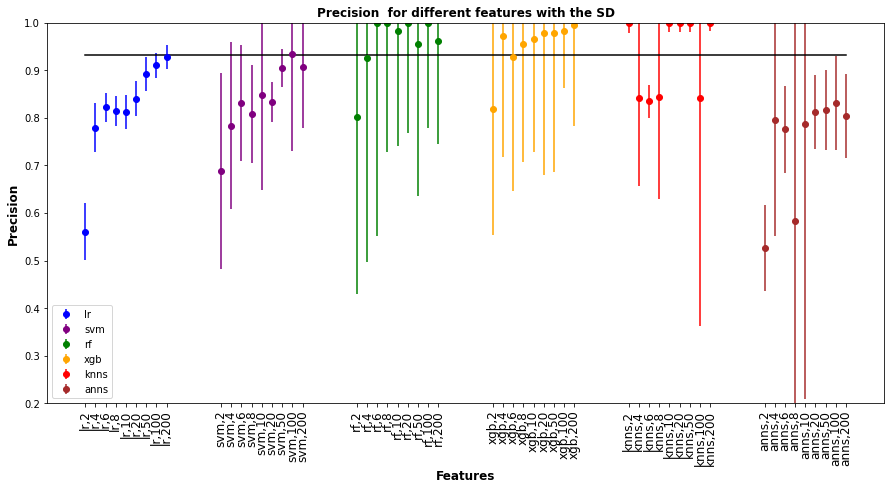

In [39]:
colors = ['blue', 'purple', 'green', 'orange', 'red', 'brown']
plt.figure(figsize=(15, 7))
plt.title( "Precision  for different features with the SD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Precision", fontweight ='bold', fontsize =12)

count = 0
n = len(colors)-1

space = []
tickFeat = []

for result, model, color in zip(arr_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,9)
    print(a)
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1

plt.plot(np.array(space),[0.932584]*54, color = 'Black')        
plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(.2, 1)
plt.legend()

plt.show()

<b><i> relative performance </i></b> 

In [34]:
arr_diff_all = []

for m, m_key in zip (models, ml_dicts.keys()):
    acc_diff_arr = [] 
    sd_diff_arr = [] 
    for f_key in ml_dicts[m_key].keys():
        value = f_key.split(',')
        acc_diff_arr.append( ml_dicts[m_key][f_key][ 'tot_acc' ] - baseDict['lr']['lr, all'][ 'tot_acc' ]  )

        sd_train = jack_SD( baseDict['lr']['lr, all'][ 'jack_train' ], ml_dicts[m_key][f_key]['jack_train'] )[0]
        sd_test = jack_SD(  baseDict['lr']['lr, all'][ 'jack_test' ],  ml_dicts[m_key][f_key]['jack_test']   )[0]

        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_diff_arr.append(sd) # append sd_arr to an array
    arr_diff_all.append([ list(ml_dicts[m_key].keys()), acc_diff_arr, sd_diff_arr]) 

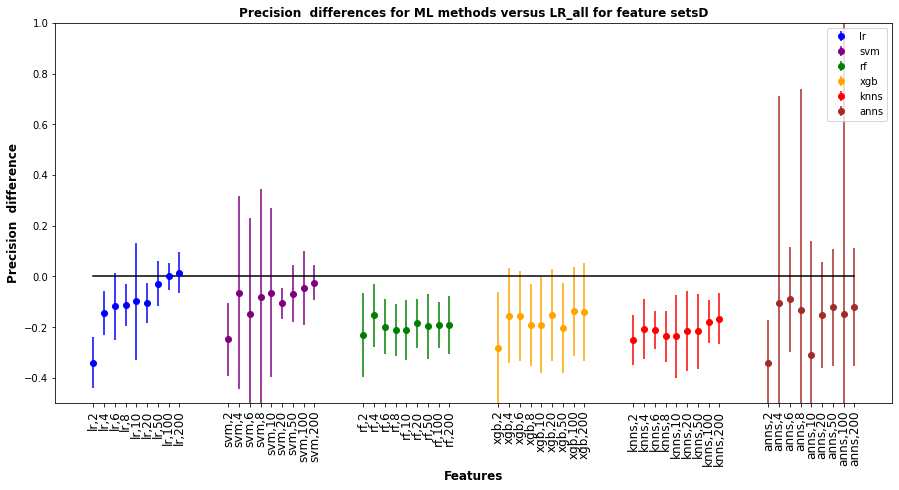

In [35]:
colors = ['blue', 'purple', 'green', 'orange', 'red', 'brown']
plt.figure(figsize=(15, 7))
plt.title( "Precision  differences for ML methods versus LR_all for feature setsD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Precision  difference", fontweight ='bold', fontsize =12)

count = 0
n = len(colors)-0.5
space = []
tickFeat = []

for result, model, color in zip(arr_diff_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,9)
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1
    
plt.plot(np.array(space), np.zeros(9*6), color = 'Black')        
plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(-.5, 1)
plt.legend()

plt.show()

In [ ]:
ll